Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For those who don't have "ECE239AS Group Project" inside "MyDrive"
# (for me, "ECE239AS Group Project" was originally in "Shared with me")
# Right click on "ECE239AS Group Project" > click "Add shortcut to drive" > click "MyDrive"
# (https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab)

% cd '/content/drive/MyDrive/ECE239AS Group Project/code'

/content/drive/.shortcut-targets-by-id/1rZR_8jRJ-D2TTGY56rMfr3FlA0ImRvbc/ECE239AS Group Project/code


In [3]:
# import libraries
!pip install box2d-py
!pip install roboschool==1.0.48 gym==0.15.4
# !pip install pybullet

import gym
import torch
import torch.nn as nn
import numpy as np
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import os
import time
from datetime import datetime
import torch.nn.functional as F
import numpy as np
import roboschool

import matplotlib.pyplot as plt

In [32]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class PPO:
	"""
	we dont need the actor critic
	 we just need to supply 2 NN modules, one is the actor one is the critic

	Update:
		we just need to get returns


	MC_function:

	TD_function: Do a little more reading
				what we need for this part


	
	"""
	def __init__(self,
				actor: nn.Module,
				critic: nn.Module,
				action_dim,
				lrate_actor,
				lrate_critic, 
				gamma, 
				epochs, 
				epsilon,
				has_continuous_action_space,
				device,
				using_TD = False,
				action_std_init=1):

		self.discount_factor = gamma
		self.device = device
		self.clip_factor = epsilon
		self.epochs = epochs
		self.buffer = RolloutBuffer()
		self.action_dim = action_dim
		self.actor = actor.to(device)
		self.critic = critic.to(device)
		self.optimizer = torch.optim.Adam(
			[ 
				{'params': self.actor.parameters(), 'lr': lrate_actor},
				{'params': self.critic.parameters(), 'lr': lrate_critic}
			]
		)
		self.using_TD = using_TD

		self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
		
		self.continuous = has_continuous_action_space

	def select_action(self, state):

		with torch.no_grad():
			state = torch.FloatTensor(state).to(self.device)
			if self.continuous:
				action_mean = self.actor(state)

				cov_mat = torch.diag(self.action_var).unsqueeze(dim=0).to(self.device).type('torch.FloatTensor')
				dist = MultivariateNormal(action_mean, cov_mat)
			else:
				action_probs = self.actor(state)
				dist = Categorical(action_probs)

		action = dist.sample()
		action_logprob = dist.log_prob(action)

		self.buffer.actions.append(action.detach())
		self.buffer.states.append(state)
		self.buffer.logprobs.append(action_logprob.detach())

		if self.continuous:
			return action.detach().cpu().numpy().flatten()

		return action.detach().item()


	def evaluate(self, state, action):

		if self.continuous:
			action_mean = self.actor(state)
			action_var = self.action_var.expand_as(action_mean)
			cov_mat = torch.diag_embed(action_var).to(self.device).type('torch.FloatTensor')
			dist = MultivariateNormal(action_mean, cov_mat)
			
			# for single action continuous environments
			if self.action_dim == 1:
				action = action.reshape(-1, self.action_dim)

		else:
			action_probs = self.actor(state)
			dist = Categorical(action_probs)

		action_logprobs = dist.log_prob(action)
		state_values = self.critic(state)
		dist_entropy = dist.entropy()

		return action_logprobs, state_values, dist_entropy

	def monte_carlo(self):

		rewards = []
		discounted_reward = 0
		for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
			if is_terminal:
				discounted_reward = 0
			discounted_reward = reward + (self.discount_factor * discounted_reward)

			rewards.insert(0, discounted_reward)
			
		# Normalizing the rewards
		rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
		rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

		return rewards

	def TD_get_advantage(self, rewards, values):

		advantages, gae = [], 0

		for i in reversed(range(len(rewards))):

			# TD error
			next_value = 0 if i + 1 == len(rewards) else values[i + 1]
			delta = rewards[i] + self.discount_factor * next_value - values[i]
			gae = delta + self.discount_factor * 0.95 * gae
			advantages.insert(0, delta)

		return torch.tensor(advantages, dtype=torch.float32).to(self.device)

	def update(self):
		# TODO: finish this up and test it around
		rewards = self.monte_carlo()

		#normalizing the rewards

		# convert list to tensor
		old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(self.device)
		old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(self.device)
		old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(self.device)
		
			

		#Optimizing for K epochs:
		for _ in range(self.epochs):

			#evaluate old actions & values
			logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
			state_values = torch.squeeze(state_values)


			if not self.using_TD:
				
				#finding the surrrogate loss
				advantage = rewards - state_values.detach() 
			else: 
				advantage = self.TD_get_advantage(self.buffer.rewards, state_values.detach())




			ratios = torch.exp(logprobs - old_logprobs)
            # Utilizing the comb
			
			#surrogate loss original
			surr1 = ratios * advantage
			#surrogate loss clipped
			surr2 = torch.clamp(ratios, 1 - self.clip_factor,1 + self.clip_factor) * advantage

			loss = -torch.min(surr1, surr2) +  0.5 * F.mse_loss(state_values, rewards) - 0.01 * dist_entropy

			# take gradient step
			self.optimizer.zero_grad() #zero out the gradients since PyTorch accumulates the gradients
			loss.mean().backward() #use backward for computational efficiency in taking gradients
			self.optimizer.step()

		self.buffer.clear()


	def save_actor(self, path):
		torch.save(self.actor.state_dict(), path) # made an edit here -terri
    
	def load_actor(self, path):
		self.actor.load_state_dict(torch.load(path, self.device)) # made an edit here - terri




In [33]:
# pytorch device (we are using cpu)
device = torch.device('cpu')

Train

In [38]:
### training setup 

# initialize enviornment 
# env = gym.make("LunarLander-v0")
# has_continuous_action_space = False

env = gym.make("RoboschoolAnt-v1")
has_continuous_action_space = True

# these enviornment attributes will be passed into training algorithm 
state_dim = env.observation_space.shape[0] 
# action_dim = env.action_space.n # for lunarlander
action_dim = env.action_space.shape[0] # for roboschoolAnt

# PPO algorithm hyerparameters
max_episode_steps = 400                  

lr_actor = 0.0003                         # actor/policy network lr
lr_critic = 0.001                          # critic/q-function network lr
update_frequency = max_episode_steps * 3  # update policy per this timestep 
k_epochs = 20                             # K num. epochs
eps_clip = 0.2                            # clipping parameter epsilon
gamma = 0.99                              # discount 

# training hyperparameters
max_training_steps = 1e5 # arbitrarily set 10k training iterations



In [39]:
### training loop

# not have continuous action space
if has_continuous_action_space:
    actor = nn.Sequential(nn.Linear(state_dim, 64),
                          nn.Tanh(),
                          nn.Linear(64, 64),
                          nn.Tanh(),
                          nn.Linear(64, action_dim),
                          nn.Tanh()
                          )
else:
    actor = nn.Sequential(nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, action_dim),
                        nn.Softmax(dim=-1)
                        )

critic = nn.Sequential(nn.Linear(state_dim, 64),
                       nn.Tanh(),
                       nn.Linear(64, 64),
                       nn.Tanh(),
                       nn.Linear(64, 1)
                       )


# initialize a PPO agent
ppo_agent = PPO(actor, 
                critic,
                action_dim,
                lr_actor,
                lr_critic,
                gamma, 
                k_epochs,
                eps_clip,
                has_continuous_action_space,
                device,
                using_TD=True)

time_step = 0
i_episode = 0

reward_log = 0
timestep_log = 0
print_freq = max_episode_steps * 4
save_freq = max_training_steps 

timestep_list = []
ave_reward_list = []


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

while time_step <= max_training_steps:
  state = env.reset()
  current_ep_reward = 0
  
  for t in range(1, max_episode_steps+1):
    # select action with policy
    action = ppo_agent.select_action(state)
    state, reward, done, _ = env.step(action)

    # saving reward and is_terminals
    ppo_agent.buffer.rewards.append(reward)
    ppo_agent.buffer.is_terminals.append(done)

    time_step +=1
    current_ep_reward += reward

    # update PPO agent
    if time_step % update_frequency == 0:
        ppo_agent.update()
    
    # print progress average reward
    if time_step % print_freq == 0: 
      current_ave = reward_log / timestep_log
      print("Elapsed Time: {} \t Episode: {} \t TimeStep: {} \t Reward: {}".format(datetime.now().replace(microsecond=0) - start_time, i_episode, time_step, current_ave))
      timestep_log = 0
      reward_log = 0
      timestep_list.append(time_step)
      ave_reward_list.append(current_ave)

    # save model weights along the way
    if time_step % save_freq == 0:
      path = '/content/drive/MyDrive/ECE239AS Group Project/code/ppo_trained_roboschool_ANT{}.pth'.format(time_step) 
      ppo_agent.save_actor(path)
      print("Model saved at t={}".format(time_step))
      # print(ppo_agent.actor.state_dict())

    if done:
      break

  reward_log += current_ep_reward
  timestep_log += 1
  i_episode += 1

env.close()

Started training at (GMT) :  2021-06-04 01:56:49
Elapsed Time: 0:00:04 	 Episode: 3 	 TimeStep: 1600 	 Reward: 55.44318243904368
Elapsed Time: 0:00:08 	 Episode: 7 	 TimeStep: 3200 	 Reward: 38.39520572117982
Elapsed Time: 0:00:13 	 Episode: 11 	 TimeStep: 4800 	 Reward: 54.92689485407861
Elapsed Time: 0:00:17 	 Episode: 15 	 TimeStep: 6400 	 Reward: 36.20675256876567
Elapsed Time: 0:00:20 	 Episode: 19 	 TimeStep: 8000 	 Reward: 43.88382100458146
Elapsed Time: 0:00:25 	 Episode: 23 	 TimeStep: 9600 	 Reward: 77.33126730742482
Elapsed Time: 0:00:29 	 Episode: 27 	 TimeStep: 11200 	 Reward: 81.0985554098028
Elapsed Time: 0:00:33 	 Episode: 31 	 TimeStep: 12800 	 Reward: 89.94410362723974
Elapsed Time: 0:00:37 	 Episode: 35 	 TimeStep: 14400 	 Reward: 88.81800970952352
Elapsed Time: 0:00:41 	 Episode: 39 	 TimeStep: 16000 	 Reward: 94.86513549490881
Elapsed Time: 0:00:45 	 Episode: 43 	 TimeStep: 17600 	 Reward: 78.5784766672903
Elapsed Time: 0:00:49 	 Episode: 48 	 TimeStep: 19200 	 Rew

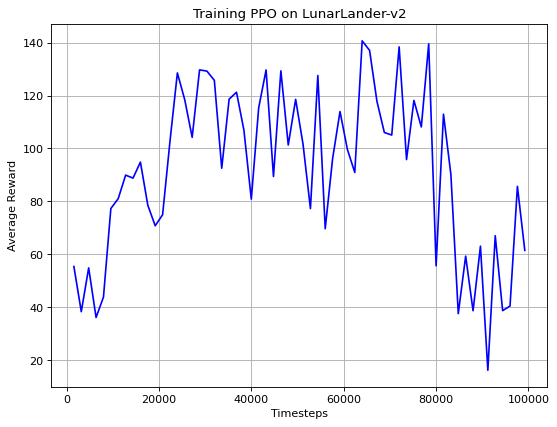

In [40]:
# plot training curve

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(timestep_list, ave_reward_list, color="blue")
plt.title("Training PPO on LunarLander-v2")
plt.xlabel("Timesteps")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

**Test - get weights**

In [ ]:
# get weights 
weights_iteration = int(max_training_steps)
get_weights_path = '/content/drive/MyDrive/ECE239AS Group Project/code/ppo_trained_nikhilparams{}.pth'.format(weights_iteration)

**Test - test many episodes & get avg reward**

In [41]:
# env = gym.make("LunarLander-v2")


# # not have continuous action space
# actor = nn.Sequential(nn.Linear(state_dim, 64),
#                       nn.Tanh(),
#                       nn.Linear(64, 64),
#                       nn.Tanh(),
#                       nn.Linear(64, action_dim),
#                       nn.Softmax(dim=-1)
#                       )

# critic = nn.Sequential(nn.Linear(state_dim, 64),
#                        nn.Tanh(),
#                        nn.Linear(64, 64),
#                        nn.Tanh(),
#                        nn.Linear(64, 1)
#                        )


# # loading 'saved weights' and check if it's the same as above

# # initialize a PPO agent
# ppo_agent = PPO(actor, 
#                 critic,
#                 action_dim,
#                 lr_actor,
#                 lr_critic,
#                 gamma, 
#                 k_epochs,
#                 eps_clip,
#                 has_continuous_action_space,
#                 device)

# #load into ppo_agent
# ppo_agent.load_actor(get_weights_path)
# #print(ppo_agent.actor.state_dict())

# test loop
num_test_episodes = 100
test_print_frequency = 10
reward_total = 0

for episode in range(num_test_episodes):
  state = env.reset()
  reward_episode = 0
  
  for t in range (1, max_episode_steps+1):
    action = ppo_agent.select_action(state)
    state, rewardt, done, _ = env.step(action)
    reward_episode += rewardt

    if done:
        break
  
  # clear buffer    
  ppo_agent.buffer.clear()
  
  if (episode % test_print_frequency ==0 ):
    print('Episode {}/{} \t Reward: {}'.format(episode+1, num_test_episodes, reward_episode))

  reward_total += reward_episode

env.close()
print('Average reward across {} episodes: {}'.format(num_test_episodes, reward_total/num_test_episodes))


Episode 1/100 	 Reward: 156.44410955705663
Episode 11/100 	 Reward: 136.76312185057182
Episode 21/100 	 Reward: 127.59606420975894
Episode 31/100 	 Reward: -9.046914110198852
Episode 41/100 	 Reward: 122.1164748809577
Episode 51/100 	 Reward: -3.8252448055456636
Episode 61/100 	 Reward: -6.6966639308026075
Episode 71/100 	 Reward: -4.434536768616819
Episode 81/100 	 Reward: -6.256775922916132
Episode 91/100 	 Reward: 80.10851911689967
Average reward across 100 episodes: 80.04072441428069


**Test - test 1 episode & save into gif (or optional render right here too)**

In [42]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from PIL import Image
import glob

Total reward at time step 1: 96.20873629890266
Total reward at time step 2: 96.22541232783406
Total reward at time step 3: 96.14380484188005
Total reward at time step 4: 95.82702156759916
Total reward at time step 5: 95.78012189982547
Total reward at time step 6: 95.61649161362003
Total reward at time step 7: 95.37260530405621
Total reward at time step 8: 95.03015038305458
Total reward at time step 9: 94.71701712322248
Total reward at time step 10: 94.62079812972371
Total reward at time step 11: 94.55946359265945
Total reward at time step 12: 94.42923235817726
Total reward at time step 13: 94.10069485054846
Total reward at time step 14: 94.03706622109313
Total reward at time step 15: 94.1552933172221
Total reward at time step 16: 94.16819691708662
Total reward at time step 17: 93.93135154397024
Total reward at time step 18: 94.13524451681006
Total reward at time step 19: 94.28846521722882
Total reward at time step 20: 94.22303029379401
Total reward at time step 21: 94.74098531852361
To

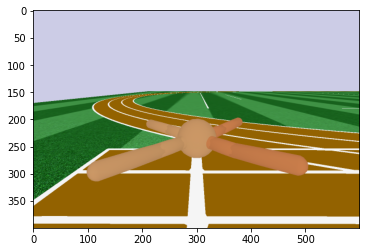

In [44]:

render_here = False # set to true if you want to see the choppy images on colab

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

env = gym.make("RoboschoolAnt-v1")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

# this is for gif-making 
save_gif_path = '/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_ant/'

# play out 1 episode
for i in range(max_episode_steps):
  action = ppo_agent.select_action(state)
  state, reward, done, info = env.step(action)
  reward_episode += reward
  print("Total reward at time step {}: {}".format(i+1, reward_episode))
  screen = env.render(mode='rgb_array')
  
  # save screen images for gif
  image_i = Image.fromarray(screen)
  image_i.save(save_gif_path + str(i).zfill(4) + '.jpg')

  # render here in colab 
  if render_here:
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

  if done:
    break

if render_here:    
  ipythondisplay.clear_output(wait=True)
  display.stop()

env.close()
print("Breaked at time step {}".format(i+1))

In [45]:
# turn saved jpegs into gif 

fp_in = "/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_ant/*"
fp_out = save_gif_path = '/content/drive/MyDrive/ECE239AS Group Project/code/gif_segments_ant/image.gif'


img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, 
         duration=200, loop=0)

In [ ]:
i

88